# Installation

In [ ]:
! pip install openai

In [ ]:
import os
import openai
# Load your API keys

openai.api_key=""
news_api_key = ""

# Model complement

We use the part of the code corresponding to the training strategy (the batch for loop) in the previous model. As before, we load the data, do a test and then define the model and train it.

Let us remember that the initial data is divided into overlapping sequences of 7. E.g. seq[0]=prices(0:6), target[0]=prices(7)...seq[1]=prices(1:7), target[1]=prices(8). The input data is unsqeezed to fit LSTM input format.



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# Load the data
data = pd.read_csv('BrentOilPricesPro.csv')
prices = data['Price'].values.astype(float)

# Normalize the data
max_price = np.max(prices)
prices /= max_price

# Prepare the input sequences
sequence_length = 7
input_sequences = []
target_prices = []
for i in range(len(prices) - sequence_length):
    seq = prices[i:i+sequence_length]
    target = prices[i+sequence_length]
    input_sequences.append(seq)
    target_prices.append(target)

In [ ]:
print(input_sequences[0]*max_price)
print(target_prices[0]*max_price)

print(input_sequences[1000]*max_price)
print(target_prices[1000]*max_price)
print(input_sequences[1001]*max_price)
print(target_prices[1001]*max_price)

print(len(input_sequences))

[18.63 18.45 18.55 18.6  18.63 18.6  18.6 ]
18.58
[19.4  19.18 19.78 19.6  19.55 19.6  19.63]
19.95
[19.18 19.78 19.6  19.55 19.6  19.63 19.95]
19.7
9004


In [ ]:
# Define the model
class OilPricePredictor(nn.Module):
    def __init__(self):
        super(OilPricePredictor, self).__init__()
        self.hidden_size = 32
        self.lstm = nn.LSTM(7, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        predictions = self.linear(lstm_out)
        return predictions

# Convert the input sequences and target prices to tensors
input_sequences = torch.tensor(input_sequences, dtype=torch.float32)
target_prices = torch.tensor(target_prices, dtype=torch.float32)

# Create an instance of the model and define the loss function
model = OilPricePredictor()
loss_fn = nn.MSELoss()


# Define the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 100
batch_size = 100

for epoch in range(num_epochs):
  for i in range(0, len(input_sequences), batch_size):
        # Get mini-batch inputs and targets
        inputs = input_sequences[i:i+batch_size]
        targets_batch = target_prices[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = loss_fn(outputs, targets_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

  if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


# Save the trained model
torch.save(model.state_dict(), 'oil_price_predictor.pt')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/100, Loss: 0.008338503539562225
Epoch: 20/100, Loss: 0.00010784741607494652
Epoch: 30/100, Loss: 0.00014756583550479263
Epoch: 40/100, Loss: 0.00015398726100102067
Epoch: 50/100, Loss: 0.00015054522373247892
Epoch: 60/100, Loss: 0.0001410555123584345
Epoch: 70/100, Loss: 0.00012728902220260352
Epoch: 80/100, Loss: 0.00011456995707703754
Epoch: 90/100, Loss: 0.0001094010949600488
Epoch: 100/100, Loss: 0.0001127249634009786


We evaluate the trained model. We pass it the entire input sequence, calculate the output, and plot it.

In [ ]:
# evaluate model:

model.eval()

with torch.no_grad():
    ...
    outputs1 = model(input_sequences.unsqueeze(1))
    print(outputs1)

tensor([[[0.1367]],

        [[0.1397]],

        [[0.1364]],

        ...,

        [[0.6604]],

        [[0.6601]],

        [[0.6622]]])


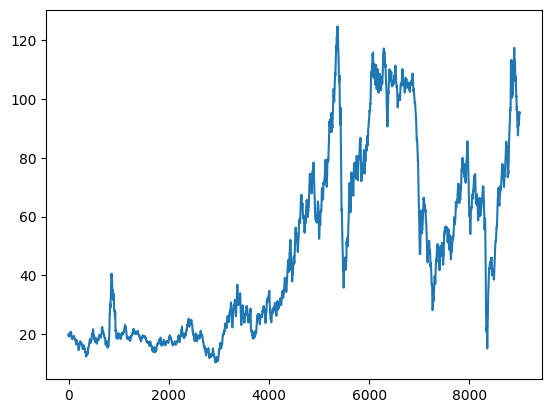

In [ ]:
import matplotlib.pyplot as plt

outputs1=torch.squeeze(outputs1)

plt.plot(outputs1*max_price)

# Model complement and knowledge generation

Test 4.0 With the model defined and trained and an external api to access oil prices (e.g. Yfinance), write code to download the data, generate output with the model and extract conclusions with the generated data (e.g. price trends).

In [ ]:
import os
import openai

client = OpenAI(
  api_key="",
)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You can write and execute Python code by enclosing it in triple backticks,\
    e.g. ```code goes here```. Use this to run the code and execute the model.\
    The user will provide you with a problem and you have to define a machine learning model with those requirements.\
    You have to define and execute the model step by step. Remember that you have to execute the Python code.\
    In a previous step you have defined a deep learning model in PyTorch to predict oil prices.\
    We have trained the model. The model is called 'model', you don't need to load it and you can evaluate it using 'model. eval()'.\
    The model has been trained with daily prices between May 1987 and November 2022.\
    The model has an input of shape (L,1,7), where L is the length of the input sequence.\
    The data has been normalized with max_price= '143.95'.\
    We want to test the model with recent data from 2023 using a external API like Yfinance and extract conclusions."},
    {"role": "user", "content":"Please give me the code in PyTorch to get the new data an test the model.\
    Write the code and use PyTorch."}
  ]
)

print(completion.choices[0].message.content)

To test the model with recent data from 2023, we can use the Yfinance library to fetch the data and then preprocess it before feeding it into the model. Here's the code to achieve that:

```python
import torch
import yfinance as yf
import numpy as np

# Fetch recent data from Yfinance
data = yf.download('OIL', start='2023-01-01', end='2023-12-31')
close_prices = data['Close'].values

# Normalize the data
max_price = 143.95
normalized_prices = close_prices / max_price

# Prepare the input sequence
input_sequence = []
for i in range(len(normalized_prices) - 7):
    input_sequence.append(normalized_prices[i:i+7])

# Convert input sequence to torch tensor
input_sequence = torch.tensor(input_sequence).unsqueeze(1).float()

# Evaluate the model on the new data
model.eval()
with torch.no_grad():
    predictions = model(input_sequence)

# Denormalize the predictions
denormalized_predictions = predictions.squeeze().numpy() * max_price

# Print the predicted prices
for i, pred in enumerate(denor

In [ ]:
import torch
import yfinance as yf
import numpy as np

# Fetch recent data from Yfinance
data = yf.download('CL=F', start='2023-01-01', end='2023-12-31')
close_prices = data['Close']

print(close_prices)

# Normalize the data
max_price = 143.95
normalized_prices = close_prices / max_price

# Prepare the input sequence
input_sequence = []
for i in range(len(normalized_prices) - 7):
    input_sequence.append(normalized_prices[i:i+7])


# Convert input sequence to torch tensor
input_sequence = torch.tensor(input_sequence).unsqueeze(1).float()

# Evaluate the model on the new data
model.eval()
with torch.no_grad():
    predictions = model(input_sequence)

# Denormalize the predictions
denormalized_predictions = predictions.squeeze().numpy() * max_price

# Print the predicted prices
for i, pred in enumerate(denormalized_predictions):
    print(f"Predicted price for day {i+1}: {pred:.2f}")

[*********************100%%**********************]  1 of 1 completed
Date
2023-01-03    76.930000
2023-01-04    72.839996
2023-01-05    73.669998
2023-01-06    73.769997
2023-01-09    74.629997
                ...    
2023-11-29    77.860001
2023-11-30    75.959999
2023-12-01    74.070000
2023-12-04    73.040001
2023-12-05    72.360001
Name: Close, Length: 234, dtype: float64
Predicted price for day 1: 76.90
Predicted price for day 2: 76.76
Predicted price for day 3: 77.76
Predicted price for day 4: 78.34
Predicted price for day 5: 78.97
Predicted price for day 6: 79.72
Predicted price for day 7: 80.54
Predicted price for day 8: 81.11
Predicted price for day 9: 81.22
Predicted price for day 10: 81.25
Predicted price for day 11: 81.47
Predicted price for day 12: 81.43
Predicted price for day 13: 80.97
Predicted price for day 14: 80.72
Predicted price for day 15: 80.03
Predicted price for day 16: 79.42
Predicted price for day 17: 78.40
Predicted price for day 18: 77.61
Predicted price fo

Evaluation. We evaluate the following aspects:

1) Ability to interact with external data. The language model code correctly use Yfinance library to download the close oil prices from the specified time range in 2023.

2) Ability to use the previous model correctly. The language model code normalize the data using the same max price value used during training, prepare the input sequence by iterating over the normalized prices and creating sequences of length 7, add a new dimension to the input sequence and convert it to torch tensor. It uses the model in evaluation mode to get the predictions, denormalize them and print them.   

3) Errors in the code. The code has no errors except that we have change the the ticker_symbol from "CL=F" to 'OIL'.